# Create animations from time raster time series

## Content
In this section we will
* load some Earth observation reflectance data from a NASA satellite mission (MODIS) in python
* derive vegetation indices from reflectance data
* combine Earth observation products with vector data (point and polygons)

## Assignments
* Test the same procedure for **1-2 further vegetation indices** (e.g. the normalized difference water index)
    * See a list of indices for MODIS here: https://github.com/awesome-spectral-indices/awesome-spectral-indices
* Test the same procedure for **other products** (e.g. the vertical optical depth data, VODCA, or the soil grids)
    * try to create a map of NDVI and a map of VODCA side by side, add a scatterplot and calculate the correlation
    * You may have to resample the raster data of different sources so that the pixels are exactly matching.
* Calculate the vegetation index standard deviation over months and correlate it with WorldClim temperature data
* Is there are relationship between temporal dynamics and biomes?


## Load Packages, etc.
...
Install packages in environment: mamba install rioxarray -c conda-forge


In [1]:
import rioxarray
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import xarray as xr
import glob
import pandas as pd
import geopandas as gpd
from rasterstats import zonal_stats
import os
import rasterio
import math

In [2]:
# Set the path to our working directory (where your data is stored)
working_directory = "G:/My Drive/teaching/2024_msc_remotesensing_geoinformatics/"
os.chdir(working_directory)

## load and inspect raster data
Try to make sense of the following outputs
* why -90 to 90
* what do x and y mean?

In [3]:
raster = rioxarray.open_rasterio("data/earth_obseration_products/modis_res/2000-2020/0.01_deg/2000-2020_sur_refl_multiyear_mean_m4_band02.tif")
print(raster.shape) # layer, rows, columns
raster

(1, 750, 1800)


<xarray.DataArray (band: 1, y: 750, x: 1800)> Size: 3MB
[1350000 values with dtype=int16]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 14kB -179.9 -179.7 -179.5 ... 179.5 179.7 179.9
  * y            (y) float64 6kB 89.9 89.7 89.5 89.3 ... -59.3 -59.5 -59.7 -59.9
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    long_name:      MODIS 2000-2020 monthly mean surface reflectance band 02 ...
    _FillValue:     -32768
    scale_factor:   1.0
    add_offset:     0.0

## Basic raster plotting
We can plot a subset by slicing the data along its x and y dimension (x = Longitude, y = Latitude)

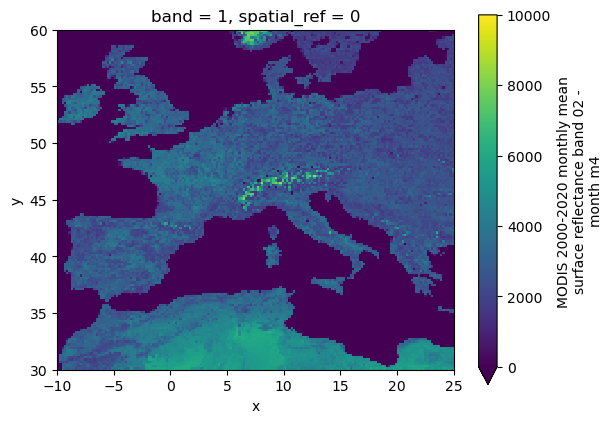

In [4]:

subset_raster = raster.sel(x=slice(-10, 25), y=slice(60, 30))
subset_raster.plot(vmin=0, vmax=10000, cmap='viridis')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

We can coarsen the raster and then plot the full extent. This often helps with large raster files

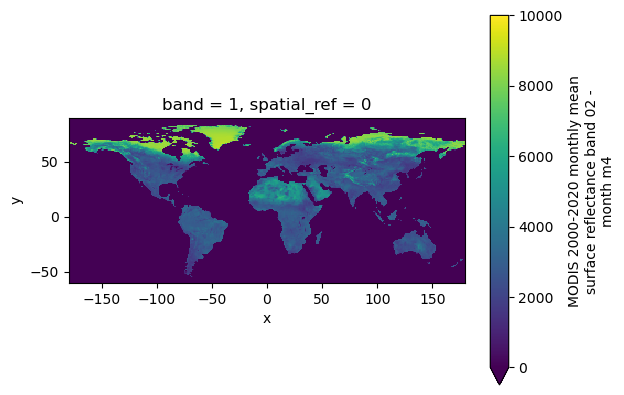

In [5]:

downsampled_raster = raster.coarsen(x=5, y=5, boundary='trim').mean()
downsampled_raster
downsampled_raster.plot(vmin=0, vmax=10000, cmap='viridis') # we no that the MODIS reflectance data is scaled betwen 0 and 10000 (--> 0 to 100%)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Loading multiple rasters in a single python object as a raster stack

In [6]:
#search rasters from files where the title contains information of a specific month (e.g. m6) and .tif extension
raster_files = glob.glob('data/earth_obseration_products/modis_res/2000-2020/0.01_deg/*m6*.tif')
raster_files[0:5] # return the first elemenets of the list of file paths

['data/earth_obseration_products/modis_res/2000-2020/0.01_deg\\2000-2020_sur_refl_multiyear_mean_m6_band01.tif',
 'data/earth_obseration_products/modis_res/2000-2020/0.01_deg\\2000-2020_sur_refl_multiyear_mean_m6_band02.tif',
 'data/earth_obseration_products/modis_res/2000-2020/0.01_deg\\2000-2020_sur_refl_multiyear_mean_m6_band03.tif',
 'data/earth_obseration_products/modis_res/2000-2020/0.01_deg\\2000-2020_sur_refl_multiyear_mean_m6_band04.tif',
 'data/earth_obseration_products/modis_res/2000-2020/0.01_deg\\2000-2020_sur_refl_multiyear_mean_m6_band05.tif']

In [7]:
# build raster stack from the list of file paths
rasters = [rioxarray.open_rasterio(rf) for rf in raster_files]
len(rasters)

5

In [8]:
rasters[0]

<xarray.DataArray (band: 1, y: 750, x: 1800)> Size: 3MB
[1350000 values with dtype=int16]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 14kB -179.9 -179.7 -179.5 ... 179.5 179.7 179.9
  * y            (y) float64 6kB 89.9 89.7 89.5 89.3 ... -59.3 -59.5 -59.7 -59.9
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    long_name:      MODIS 2000-2020 monthly mean surface reflectance band 01 ...
    _FillValue:     -32768
    scale_factor:   1.0
    add_offset:     0.0

## Calculate a vegetation index index (e.g. vegetation indices)
See for example, the NDVI: https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index

In [9]:
# Calculate NDVI
def calculate_ndvi(nir_band, red_band):
    ndvi = (nir_band - red_band) / (nir_band + red_band)
    return ndvi

ndvi = calculate_ndvi(rasters[1], rasters[0])

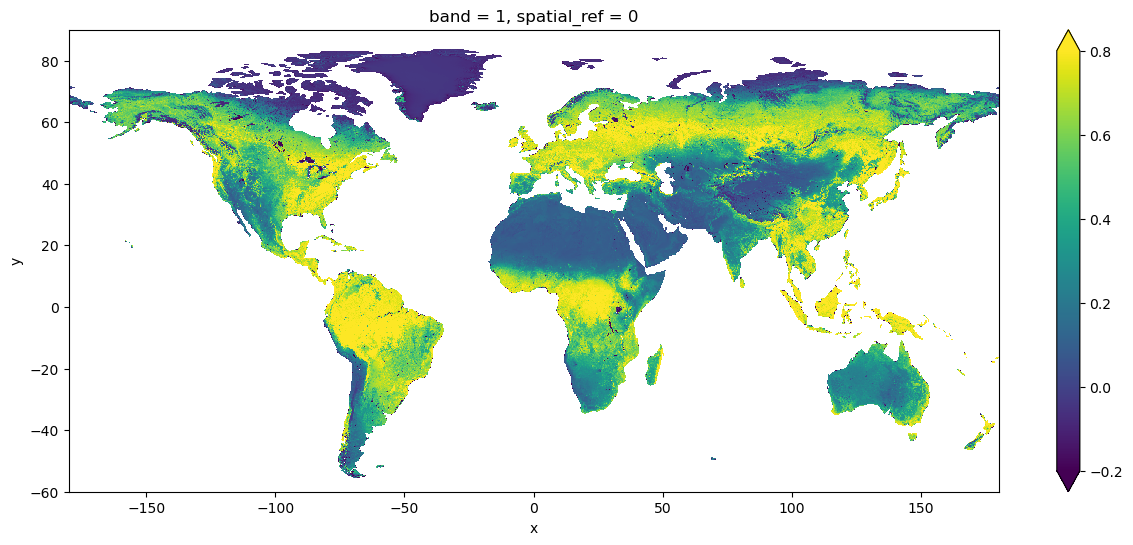

In [10]:
plt.figure(figsize=(15, 6)) # Set the figure size
ndvi.where(ndvi[0] != 0).plot(vmin=-0.2, vmax=0.8) # plot with masking values that are no data (= 0)

## Combine raster data with point data
Here we will use sPlotOpen. sPlotopen is a database that curates vegetation plots (typically areas of 1 to 10000 m²), where experts measured the species composition (e.g. the % cover of different species).
Find more info at:
* https://onlinelibrary.wiley.com/doi/full/10.1111/geb.13346
* https://www.idiv.de/de/splot/splotopen.html

The sPlot team assigned each plot to a biome. We will use this information to get a better understanding what the NDVI values actually represent; in other words: What NDVI values can we expect for different biomes.

In [11]:
# load the raw table data as data frame
df = pd.read_csv("data/sPlotOpen_original_3474_76_Dataset/sPlotOpen_header.txt", sep="\t")

# convert the data frame to a GeoDataFrame using geopandas
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
gdf.head()

C:\Users\teja\AppData\Local\Temp\ipykernel_27808\2616316559.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/sPlotOpen_original_3474_76_Dataset/sPlotOpen_header.txt", sep="\t")


,PlotObservationID,GIVD_ID,Dataset,Continent,Country,Biome,Date_of_recording,Latitude,Longitude,Location_uncertainty,...,Height_herbs_average,Height_herbs_lowest,Height_herbs_highest,SoilClim_PC1,SoilClim_PC2,Resample_1,Resample_2,Resample_3,Resample_1_consensus,geometry
0,16,NA-US-014,Aava,North America,United States,Boreal zone,1980-01-01,62.42,-154.18,1000.0,...,NaN,NaN,NaN,-3.66,0.546,True,False,False,True,POINT (-154.18000 62.42000)
1,17,NA-US-014,Aava,North America,United States,Boreal zone,1980-01-01,62.42,-154.18,1000.0,...,NaN,NaN,NaN,-3.66,0.546,True,False,False,True,POINT (-154.18000 62.42000)
2,18,NA-US-014,Aava,North America,United States,Boreal zone,1980-01-01,62.42,-154.18,1000.0,...,NaN,NaN,NaN,-3.66,0.546,False,False,True,False,POINT (-154.18000 62.42000)
3,20,NA-US-014,Aava,North America,United States,Boreal zone,1980-01-01,62.42,-154.18,1000.0,...,NaN,NaN,NaN,-3.66,0.546,False,True,False,False,POINT (-154.18000 62.42000)
4,22,NA-US-014,Aava,North America,United States,Boreal zone,1980-01-01,62.42,-154.18,1000.0,...,NaN,NaN,NaN,-3.66,0.546,True,False,False,True,POINT (-154.18000 62.42000)


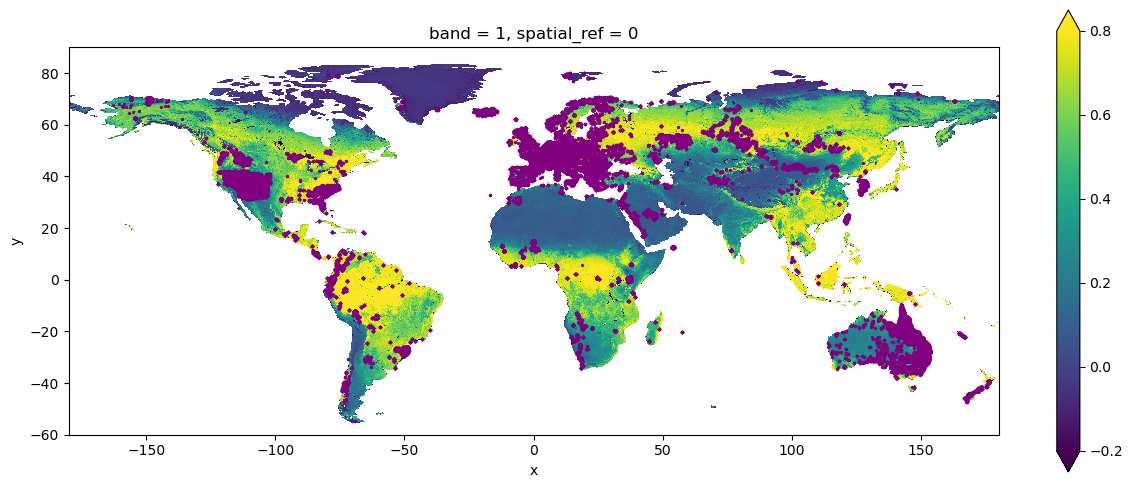

In [12]:
# overlay the raster with the points from the geo data frame
plt.figure(figsize=(15, 6)) # Set the figure size
ndvi.where(ndvi[0] != 0).plot(vmin=-0.2, vmax=0.8)
gdf.plot(ax=plt.gca(), color='purple', markersize=2)
plt.show()

Now we want to sample the NDVI values at the plot (point) location. This is not (yet) possible from rioxarray - we need to convert the raster to a rasterio object.

In [13]:
os.makedirs("exports", exist_ok=True)
ndvi.rio.to_raster("exports/ndvi.tif")
with rasterio.open("exports/ndvi.tif") as src:
    values = src.sample(gdf.geometry.apply(lambda x: (x.x, x.y)))
    values = np.asarray(list(values))

In [14]:
# add the sampled values to the gdf data frame
gdf["ndvi"] = values

Plot a histogram for each biome:

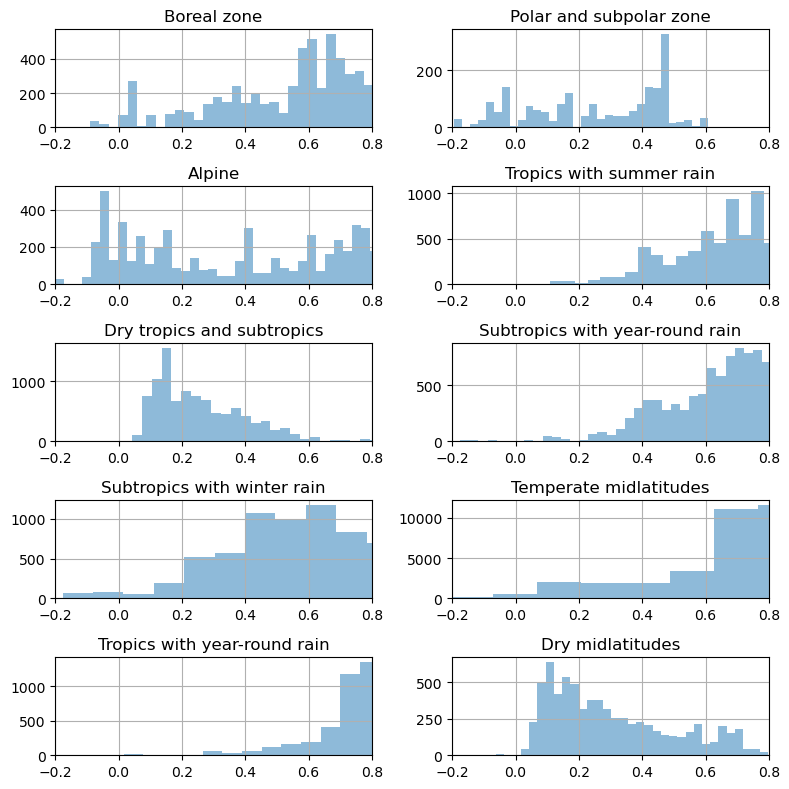

In [15]:
# list the unique values in the Biome column 
unique_biomes = gdf["Biome"].unique()
n = len(unique_biomes)

# define how many rows and columns we need for the histograms
rows = math.ceil(n/2)
cols = 2

fig, axs = plt.subplots(rows, cols, figsize=(8, 8))

# plot the histograms for each biome using a loop
for i, biomes in enumerate(unique_biomes):
    row = i // cols
    col = i % cols
    gdf[gdf["Biome"] == biomes].ndvi.hist(ax=axs[row, col], bins=50, alpha=0.5, label=biomes)
    axs[row, col].set_title(biomes)
    axs[row, col].set_xlim(-0.2, 0.8)
    #axs[row, col].legend()

plt.tight_layout()
plt.show()

## Combine raster data with polygon data
The exercise using the point data (sPlotOpen) revealed nice patterns. However, these point observations are probably not globally representative (particularly in the tropics). Let´s explore a spatially continuous dataset of biomes in the form of polygons.

We will use the biome data of the Nature Conservancy, which classifies the terrestrial land surface into 16 classes. More info at:
* https://geospatial.tnc.org/datasets/TNC::terrestrial-ecoregions/explore?
* https://geospatial.tnc.org/datasets/b1636d640ede4d6ca8f5e369f2dc368b/about

In [16]:

# load and inspect the data
gdf = gpd.read_file("data/biomes/nature_conservancy_terrestrial_ecoregions.gpkg")
gdf.head()

,ECO_ID_U,ECO_CODE,ECO_NAME,ECO_NUM,ECODE_NAME,CLS_CODE,ECO_NOTES,WWF_REALM,WWF_REALM2,WWF_MHTNUM,WWF_MHTNAM,RealmMHT,ER_UPDATE,ER_DATE_U,ER_RATION,SOURCEDATA,GlobalID,geometry
0,10000,AA0101,Admiralty Islands Lowland Rain Forests,1,AA0101. Admiralty Islands lowland rain forests,0,,AA,Australasia,1,Tropical and Subtropical Moist Broadleaf Forests,AA1,,,,"Olson, 2001",{E81ABC84-F511-4A87-9D06-F684051201BD},"MULTIPOLYGON (((16351553.019 -219264.644, 1634..."
1,10001,AA0102,Banda Sea Islands Moist Deciduous Forests,2,AA0102. Banda Sea Islands moist deciduous forests,0,,AA,Australasia,1,Tropical and Subtropical Moist Broadleaf Forests,AA1,,,,"Olson, 2001",{18DA37FB-B0E9-4B54-A945-4F34ABBE5291},"MULTIPOLYGON (((14686224.566 -793302.016, 1468..."
2,10002,AA0103,Biak-Numfoor Rain Forests,3,AA0103. Biak-Numfoor rain forests,0,,AA,Australasia,1,Tropical and Subtropical Moist Broadleaf Forests,AA1,,,,"Olson, 2001",{99CF0986-9C49-4CFB-8DC9-C35A44D89A4A},"MULTIPOLYGON (((15074541.461 -72818.979, 15074..."
3,10003,AA0104,Buru Rain Forests,4,AA0104. Buru rain forests,0,,AA,Australasia,1,Tropical and Subtropical Moist Broadleaf Forests,AA1,,,,"Olson, 2001",{04C076EE-A103-4E84-82E9-5F798F6055A6},"MULTIPOLYGON (((14102888.175 -340766.248, 1410..."
4,10004,AA0105,Central Range Montane Rain Forests,5,AA0105. Central Range montane rain forests,0,,AA,Australasia,1,Tropical and Subtropical Moist Broadleaf Forests,AA1,,,,"Olson, 2001",{119E70F6-FFB2-4BEE-81CB-7309BFC70D3C},"MULTIPOLYGON (((15253961.774 -333306.347, 1524..."


<Axes: >

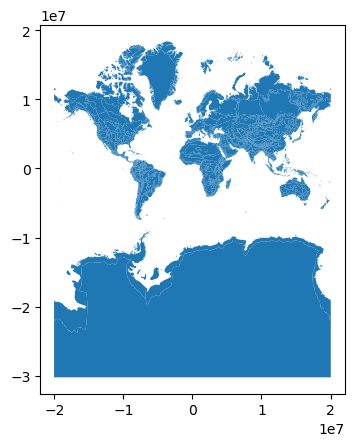

In [17]:
gdf.plot()

### Excursion: coordinate reference systems (CRS)
If we want to combine spatial data, we should make sure that the data are in the same CRS. The CRS defines how location around the globe are translated into numbers (e.g. meters or degrees). Most CRS translate locations around the Earth (3D) into a 2D representaiton. This comes with multiple challanges and therefore different coordinate reference systems exists. Let´s explore if the polygon data of the Nature Conservancy Terrestrial Ecoregions and the raster data of the NDVI have the same CRS. For this, we will compare the EPSG codes, which are standardized IDs for different CRS.

In [18]:
gdf.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
print(ndvi.rio.crs)

EPSG:4326


We found different EPSG codes. This is not a problem, we can reproject the locations of the geo dataframe to match those of the raster.

<Axes: >

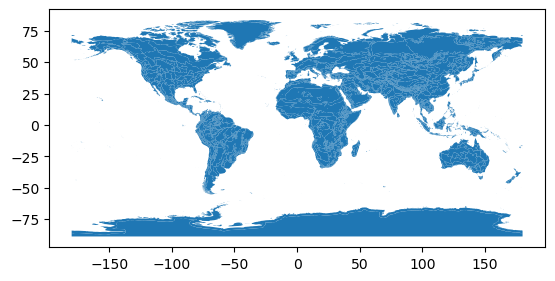

In [20]:
# transform the gdf to the same crs as the raster
gdf = gdf.to_crs(ndvi.rio.crs)
gdf.plot()

## Zonal statistics
We are almost ready to extract the NDVI values for the different biomes. Before we proceed, we want to merge the subregions visible above using a dissolve function.

In [21]:
gdf_merge = gdf.dissolve(by="WWF_MHTNAM")

In [22]:
print("Length:", len(gdf_merge))
print(gdf_merge.index)

Length: 16
Index(['Boreal Forests/Taiga', 'Deserts and Xeric Shrublands',
       'Flooded Grasslands and Savannas', 'Inland Water', 'Mangroves',
       'Mediterranean Forests, Woodlands and Scrub',
       'Montane Grasslands and Shrublands', 'Rock and Ice',
       'Temperate Broadleaf and Mixed Forests', 'Temperate Conifer Forests',
       'Temperate Grasslands, Savannas and Shrublands',
       'Tropical and Subtropical Coniferous Forests',
       'Tropical and Subtropical Dry Broadleaf Forests',
       'Tropical and Subtropical Grasslands, Savannas and Shrublands',
       'Tropical and Subtropical Moist Broadleaf Forests', 'Tundra'],
      dtype='object', name='WWF_MHTNAM')


In [23]:
stats = zonal_stats(gdf_merge, "ndvi.tif", -999)

c:\Users\teja\miniforge3\envs\msc_remote_sens_2024\lib\site-packages\rasterstats\io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


In [24]:
df_stats = pd.DataFrame(stats)
df_stats.index = gdf_merge.index
df_stats.head()

,min,max,mean,count
WWF_MHTNAM,,,,
Boreal Forests/Taiga,-0.594878,0.885702,0.578083,65675
Deserts and Xeric Shrublands,-0.770925,0.857109,0.168368,65507
Flooded Grasslands and Savannas,-0.777778,0.885275,0.472623,2515
Inland Water,-13.000000,inf,inf,799
Mangroves,-0.440457,0.861293,0.581558,605


Text(0.5, 0, 'NDVI mean')

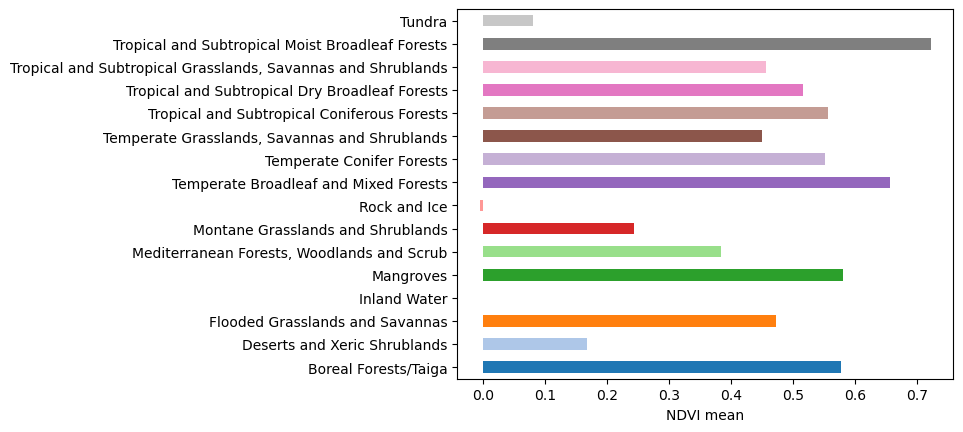

In [25]:
# create a barplot of the mean column of the zonal statistics and the index name of the zone
ax = df_stats['mean'].plot(kind='barh', color=plt.cm.tab20.colors)
ax.set_ylabel("")
ax.set_xlabel("NDVI mean")

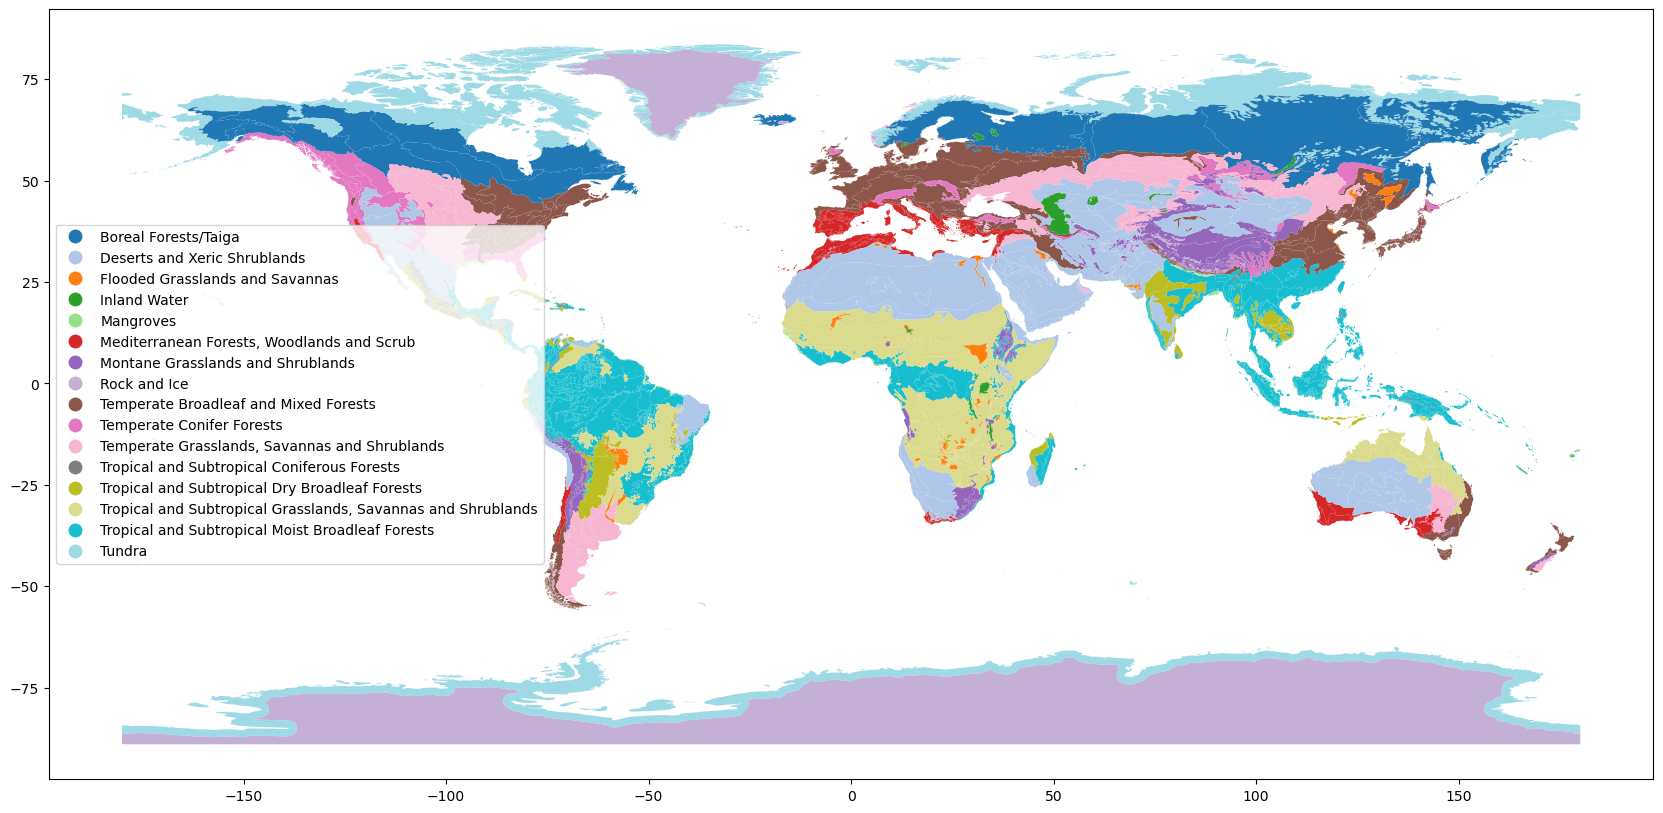

In [26]:
# Plot the biome data in space for a comparison
fig, ax = plt.subplots(figsize=(60, 10))

# Plot the GeoDataFrame with a specified column and legend
gdf.plot(column="WWF_MHTNAM", legend=True, cmap="tab20" , ax=ax, legend_kwds={'loc': 'center left'})

# Show the plot
plt.show()

In [27]:
unique_values = gdf_merge['ECODE_NAME'].unique()
color_mapping = {val: plt.cm.tab20.colors[i] for i, val in enumerate(unique_values)}
gdf_merge['colors'] = gdf_merge['ECODE_NAME'].map(color_mapping)

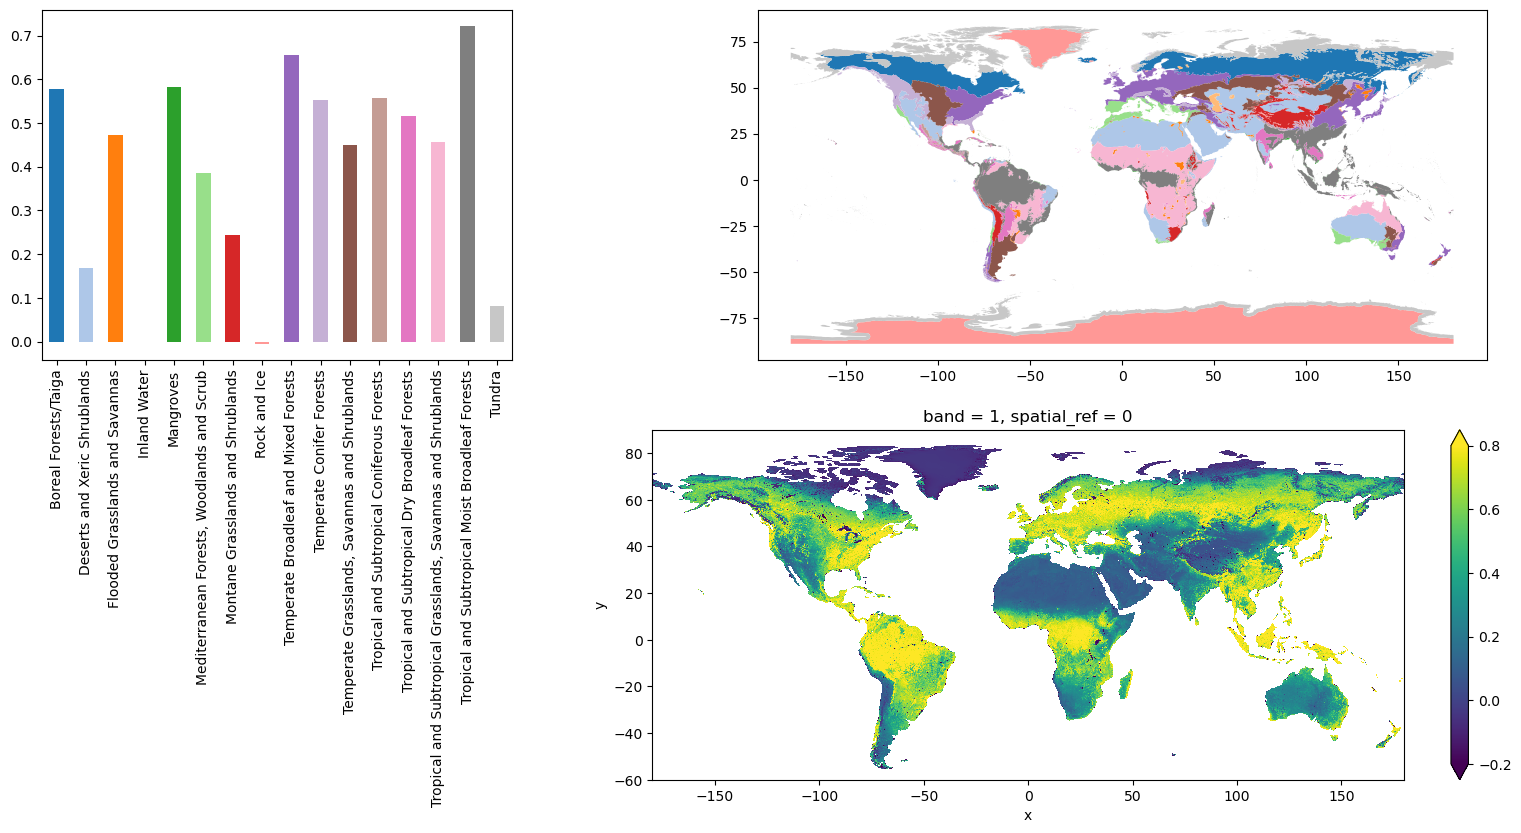

In [28]:

# Create subplots with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(20, 10), gridspec_kw={'width_ratios': [1, 2]})

# Plot the bar chart on the first subplot (axs[0, 0])
#df_stats['mean'].plot(kind='bar', color=plt.cm.tab20.colors, ax=axs[0, 0])
df_stats['mean'].plot(kind='bar', color=gdf_merge['colors'], ax=axs[0, 0])

axs[0, 0].set_xlabel("")  # Set x-axis label to empty string

# Plot the first GeoDataFrame on the second subplot (axs[0, 1])
#gdf.plot(column="WWF_MHTNAM", legend=False, cmap="tab20" , ax=axs[0, 1], legend_kwds={'loc': 'center left'})
gdf_merge.plot(color=gdf_merge['colors'], ax=axs[0, 1])

# Plot the second GeoDataFrame on the third subplot (axs[1, 1]), assuming you have another GeoDataFrame called gdf2
ndvi.where(ndvi[0] != 0).plot(vmin=-0.2, vmax=0.8)

# Remove the empty subplot in the bottom left
fig.delaxes(axs[1, 0])

# Show the plot
plt.show()